In [1]:
import sys
import json
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../..')
from scanpy import AnnData
from itertools import chain
from utils import UnimapResult, set_plot_theme

set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pbmc_query = sc.read_h5ad( '../../data/pbmc40/pbmc10.h5ad')
pbmc_hvgs = pkl.load(open( '../../data/pbmc40/hvg_1582_pbmc40.pkl', "rb"))
result = UnimapResult('pbmc40', 'unimap/2023', root_dir='../../results')

color_dict = json.load(open('../../color_dict.json'))
ct_c = color_dict["pbmc40_ct_query"]
ct_order = color_dict["pbmc40_ct_query_order"]

Checking pbmc40 unimap/2023 result 
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ File                 ┃ Exist    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ st_result.csv        │ ✔️        │
│ history.csv          │ ✔️        │
│ st_z_result.csv      │ ✔️        │
│ st_umap_result.csv   │ ✔️        │
│ t_prob_result.csv    │ ✔️        │
└──────────────────────┴──────────┘

In [3]:
pbmc_query.obs = pd.concat([pbmc_query.obs, result.t_result.loc[:, ['pred_celltype', 'pred_cell_prob']]], axis=1)
pbmc_query.var_names_make_unique()
pbmc_query = pbmc_query[pbmc_query.obs['celltype'] != 'nan', :]
sc.pp.filter_cells(pbmc_query, min_genes=200)
sc.pp.filter_genes(pbmc_query, min_cells=3)
sc.pp.normalize_total(pbmc_query, target_sum=1e6)  # cpm
sc.pp.log1p(pbmc_query)
pbmc_query = pbmc_query[:, pbmc_query.var.index.isin(pbmc_hvgs)]
pbmc_query.raw = pbmc_query
pbmc_query.obsm['X_umap'] = result.t_umap_result.reindex(pbmc_query.obs_names).to_numpy()
pbmc_query.obsm['X_pca'] = result.t_z_result.reindex(pbmc_query.obs.index).values

pd_no_monocyte = pbmc_query[(~pbmc_query.obs['pred_celltype'].isin(['CD14-positive monocyte'])) | (pbmc_query.obs['celltype'].isin(['monocyte'])), :].copy()

In [4]:
# sc.tl.rank_genes_groups(pd_no_monocyte, "celltype", method="t-test")
pd_mono_marker_dict = {
 'B cell': ['CD79A', 'MS4A1'],
 'alpha-beta T cell': ['TSHZ2', 'SERINC5'],
 'CD4-positive, alpha-beta T cell': ['LTB', 'IL7R'],
 'CD8-positive, alpha-beta T cell': ['NKG7', 'CST7'],
 'natural killer cell': ['CTSW', 'PRF1'],
 'plasmablast': ['JCHAIN', 'MZB1'],
 'dendritic cell': ['LYZ', 'CST3'],
 'plasmacytoid dendritic cell': ['TPM2', 'LILRA4'],
 'platelet': ['PPBP', 'PF4'],
 'monocyte': ['FCN1', 'CD14',]}

pd_mono_marker_list = list(chain.from_iterable(pd_mono_marker_dict.values()))

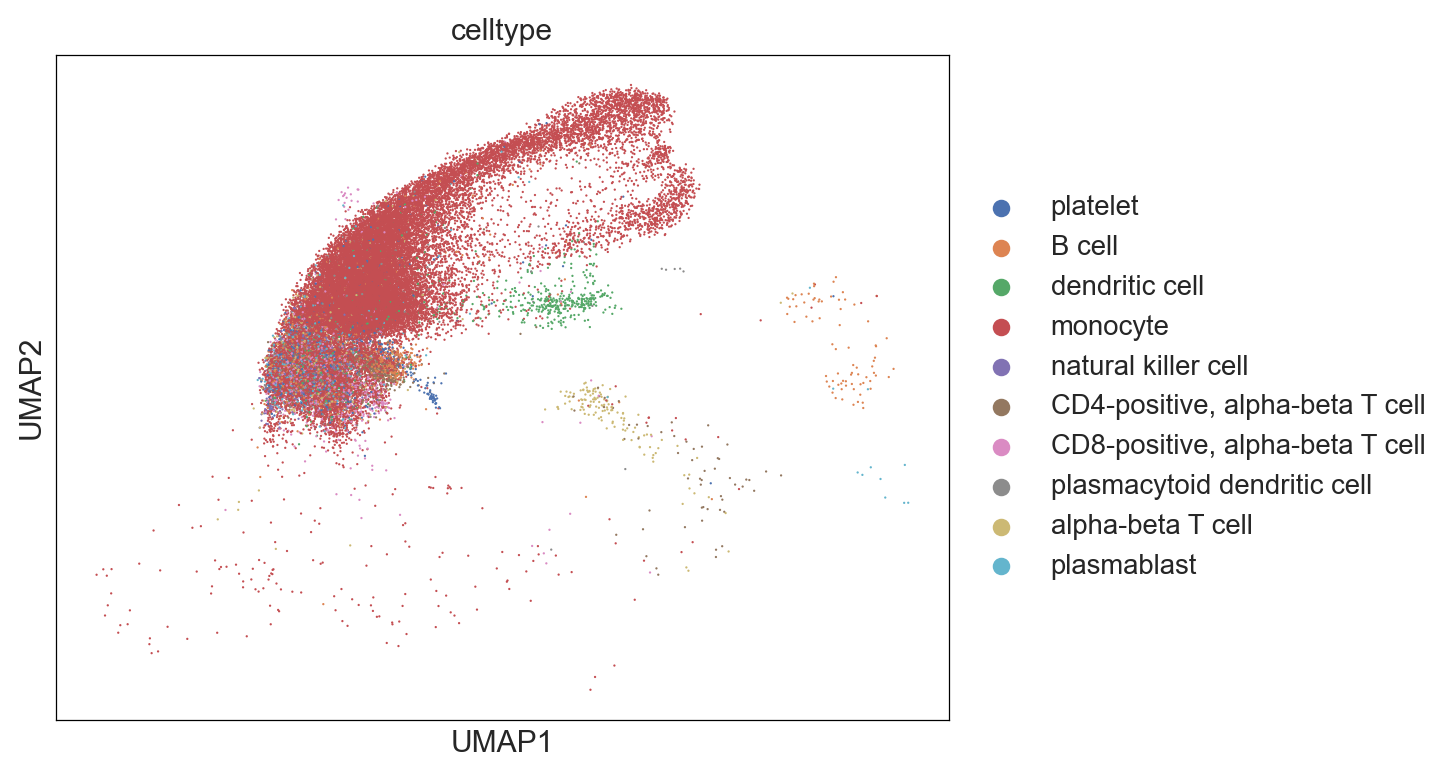

In [5]:
pbmc_query.obsm['X_pca'] = result.t_z_result.reindex(pbmc_query.obs.index).values
pd_monocyte = pbmc_query[(pbmc_query.obs['pred_celltype'].isin(['CD14-positive monocyte'])) | (pbmc_query.obs['celltype'].isin(['monocyte'])), :].copy()  # 
sc.pp.neighbors(pd_monocyte, n_neighbors=10, n_pcs=128)
sc.pl.umap(pd_monocyte, color=['celltype'])

In [6]:
def cal_gene(adata: AnnData, gene_list: list, groupby_column: str) -> pd.DataFrame:
    valid_genes = [gene for gene in gene_list if gene in adata.var_names]
    expression_matrix = adata[:, valid_genes].X
    groups = adata.obs[groupby_column]

    if not isinstance(expression_matrix, np.ndarray):
        expression_matrix = expression_matrix.toarray()

    results = {
        'group': [],
        'gene': [],
        'expression_proportion': [],
        'average_expression': []
    }

    for group in groups.unique():
        group_mask = (groups == group).values
        group_expression = expression_matrix[group_mask, :]
        
        expression_proportion = (group_expression > 0).sum(axis=0) / group_expression.shape[0]
        average_expression = group_expression.mean(axis=0)
        
        for gene, prop, avg in zip(valid_genes, expression_proportion, average_expression):
            results['group'].append(group)
            results['gene'].append(gene)
            results['expression_proportion'].append(prop)
            results['average_expression'].append(avg)

    return pd.DataFrame(results)


def plot_dotplot(adata: AnnData, gene_list: list, groupby_column: str, ax=None, group_color=['#a0a0a0', '#c3a74d'], group_index=None):
    df = cal_gene(adata, gene_list, groupby_column)
    df['gene'] = pd.Categorical(df['gene'], categories=gene_list, ordered=True) 
    df = df.sort_values('gene')
    gene_num = len(gene_list)
    if group_index is None:
        unique_groups = df['group'].unique()
    else:
        unique_groups = group_index
    df['group'] = pd.Categorical(df['group'], categories=unique_groups[::-1], ordered=True) 
    group_num = len(unique_groups)
    p = sns.scatterplot(data=df, x='gene', y='group', size='expression_proportion', hue='average_expression', palette='viridis', sizes=(0, 35), edgecolor='black', linewidth=0.5, ax=ax)
    p.legend_.remove()
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_xlim(-1, gene_num)
    p.set_ylim(-0.5, group_num - 0.5)
    
    p.set_xticklabels(gene_list, fontsize=5, fontstyle='italic', rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    p.set_yticklabels(unique_groups[::-1], fontsize=5)
    # p.xaxis.tick_top()
    p.xaxis.set_tick_params(labelsize=5, pad=2)
    p.yaxis.set_tick_params(labelsize=5, pad=0)
    p.tick_params(bottom=True, top=False, left=True, right=False, length=3, width=0.5)
    



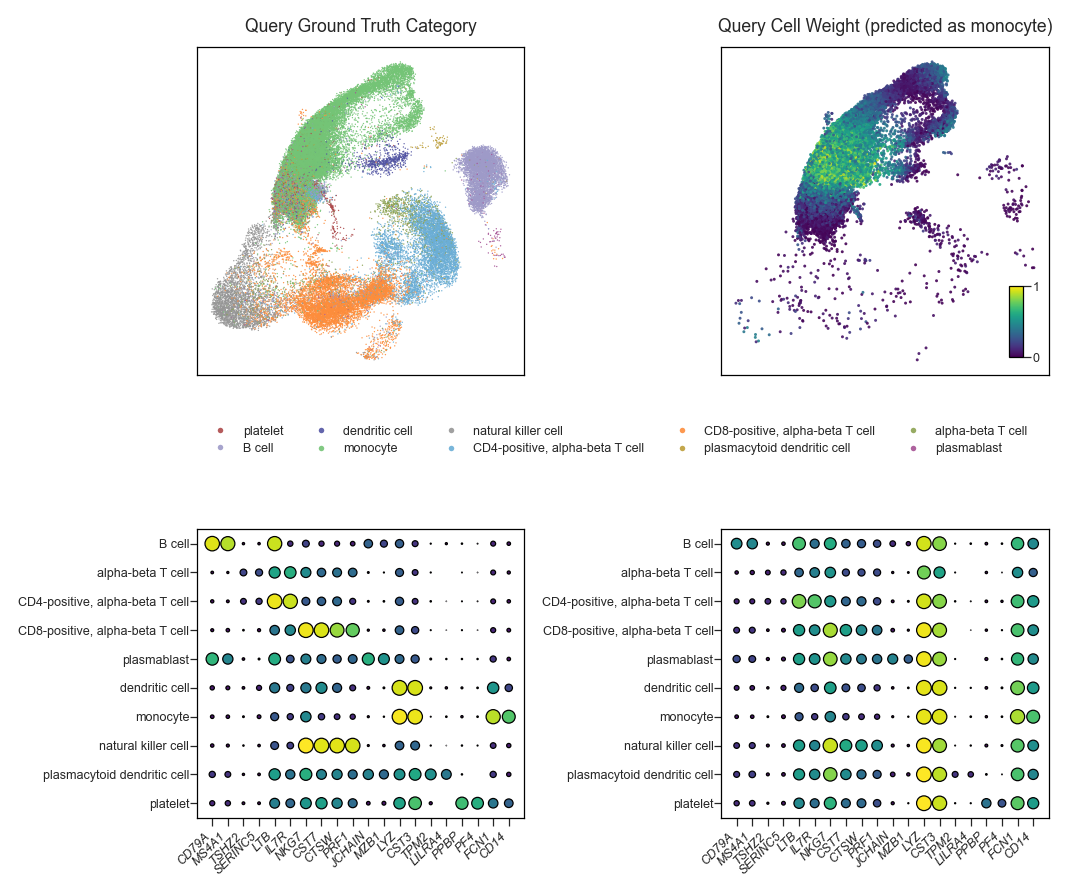

In [7]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

postions = [[0.20, 0.70, 0.25, 0.25 / (250/185)],
            [0.60, 0.70, 0.25, 0.25 / (250/185)],
            [0.20, 0.45, 0.25, 0.22 / (250/185)],
            [0.60, 0.45, 0.25, 0.22 / (250/185)]]
ax1 = fig.add_axes(postions[0])
ax2 = fig.add_axes(postions[1])
ax3 = fig.add_axes(postions[2])
ax4 = fig.add_axes(postions[3])

categories_order = ['B cell', 'alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'natural killer cell', 'plasmablast', 'dendritic cell', 'plasmacytoid dendritic cell', 'platelet', 'monocyte']
plot_dotplot(pd_no_monocyte, pd_mono_marker_list, groupby_column='celltype', ax=ax3, group_index=ct_order)
plot_dotplot(pd_monocyte, pd_mono_marker_list, groupby_column='celltype', ax=ax4, group_index=ct_order)

p1 = sns.scatterplot(x=pbmc_query.obsm['X_umap'][:,0],
                     y=pbmc_query.obsm['X_umap'][:,1],
                     alpha=0.9, s=0.3,
                     hue=pbmc_query.obs.celltype,
                     edgecolor='none',
                     palette=ct_c,
                     ax=ax1, rasterized=True)
p2 = sns.scatterplot(x=pd_monocyte.obsm['X_umap'][:,0],
                     y=pd_monocyte.obsm['X_umap'][:,1],
                     alpha=0.9, s=1.4,
                     hue=pd_monocyte.obs.pred_cell_prob.rank(method='dense', ascending=False),
                     edgecolor='none',
                     palette='viridis_r',
                     ax=ax2, rasterized=True)

cbar_ax = fig.add_axes([0.82, 0.71, 0.01, 0.04])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'],)
cbar.ax.tick_params(labelsize=5, length=3, pad=1, width=0.5)

result.remove_ticks(p1)
result.remove_ticks(p2)
p1.legend(loc='center left', bbox_to_anchor=(0, -0.2), frameon=False, markerscale=4, fontsize=5, labelspacing=0.4, ncol=5)
p2.legend_.remove()
p1 = p1.set_title('Query Ground Truth Category', fontsize=7)
p2 = p2.set_title('Query Cell Weight (predicted as monocyte)', fontsize=7)



In [8]:
# fig.savefig('../figs/supplementary fig8.pdf', dpi=720)
# fig.savefig('../sup_figs/sup8.png', dpi=720)